# Amazon climate Forecasting with Granite Timeseries (TTM)

TinyTimeMixers (TTMs) are compact pre-trained models for Multivariate Time-Series Forecasting, open-sourced by IBM Research. With less than 1 Million parameters, TTM introduces the notion of the first-ever "tiny" pre-trained models for Time-Series Forecasting. TTM outperforms several popular benchmarks demanding billions of parameters in zero-shot and few-shot forecasting and can easily be fine-tuned for multi-variate forecasts.

# Load the data

Adjust the paths as required

In [253]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [254]:
import matplotlib.pyplot as plt
import pandas as pd
import torch

In [255]:
file_path = '/content/drive/MyDrive/Impactastic/Amazon_data.csv' # Paste your copied path here
df = pd.read_csv(file_path)

In [256]:
# --- 2. Data Cleaning & Preprocessing ---
print("\n--- 2. Data Cleaning & Preprocessing ---")

# Create a proper datetime index
try:
    df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
    df = df.set_index('date')
    #df = df.drop(columns=['year', 'month'])
    print("Successfully created and set datetime index.")
except Exception as e:
    print(f"Error creating datetime index: {e}")

# Check for missing values
missing_values = df.isnull().sum()
print(f"\nMissing values BEFORE interpolation:\n{missing_values[missing_values > 0]}")

# Interpolate missing values using time-based method
df.interpolate(method='time', inplace=True)

# Check if any missing values remain (e.g., at the very start)
remaining_missing = df.isnull().sum().sum()
if remaining_missing > 0:
    print(f"Warning: {remaining_missing} missing values remain. Filling with backward/forward fill.")
    df.fillna(method='bfill', inplace=True)
    df.fillna(method='ffill', inplace=True)

print("Missing values have been interpolated.")


--- 2. Data Cleaning & Preprocessing ---
Successfully created and set datetime index.

Missing values BEFORE interpolation:
Series([], dtype: int64)
Missing values have been interpolated.


Define date variables:

In [257]:
df2= df
df2['date_full'] = pd.to_datetime(df2[['year', 'month']].assign(day=1))
df2['date_full'].tail()

df2['date_ym']=pd.to_datetime(df['date_full'],format='%m%Y', errors='coerce').dt.to_period('M')
df2[['date_full','date_ym']].tail()


,date_full,date_ym
date,,
2023-08-01,2023-08-01,2023-08
2023-09-01,2023-09-01,2023-09
2023-10-01,2023-10-01,2023-10
2023-11-01,2023-11-01,2023-11
2023-12-01,2023-12-01,2023-12


In [258]:
df2.columns

Index(['year', 'month', 'pre_Region1', 'pre_Region2', 'pre_Region3',
       'pre_Region4', 'pre_Region5', 'pre_Region6', 'tmp_Region1',
       'tmp_Region2', 'tmp_Region3', 'tmp_Region4', 'tmp_Region5',
       'tmp_Region6', 'spi3_1', 'spi3_2', 'spi3_3', 'spi3_4', 'spi3_5',
       'spi3_6', 'tmp3m_1', 'tmp3m_2', 'tmp3m_3', 'tmp3m_4', 'tmp3m_5',
       'tmp3m_6', 'date_full', 'date_ym'],
      dtype='object')

In [113]:
df2.tail()

,year,month,pre_Region1,pre_Region2,pre_Region3,pre_Region4,pre_Region5,pre_Region6,tmp_Region1,tmp_Region2,...,tmp3m_2,tmp3m_3,tmp3m_4,tmp3m_5,tmp3m_6,date,date3,date2,date_full,date_ym
date,,,,,,,,,,,,,,,,,,,,,
2023-08-01,2023,8,176.727935,231.819875,73.551209,42.047854,26.296000,22.912384,26.530785,25.695904,...,25.451641,27.401953,26.380388,25.031470,14.428061,2023-08,2023-08,2023-08,2023-08-01,2023-08
2023-09-01,2023,9,193.534884,188.500714,43.381793,84.019408,42.234700,34.566617,27.067162,26.570827,...,25.865733,27.816269,26.928045,26.363528,14.948088,2023-09,2023-09,2023-09,2023-09-01,2023-09
2023-10-01,2023,10,182.324357,175.697296,49.953318,146.063101,97.397818,73.082542,27.066964,26.558969,...,26.275234,28.304527,27.407523,27.599649,15.303076,2023-10,2023-10,2023-10,2023-10-01,2023-10
2023-11-01,2023,11,198.565233,156.594938,76.335881,183.652363,149.894252,86.235982,27.162466,26.287492,...,26.472430,28.471129,27.488949,28.059221,15.558299,2023-11,2023-11,2023-11,2023-11-01,2023-11
2023-12-01,2023,12,230.943498,108.029239,151.216625,251.643032,179.187970,103.013639,26.627178,25.734410,...,26.193624,28.284615,27.289871,27.766117,15.420441,2023-12,2023-12,2023-12,2023-12-01,2023-12


### Install the TSFM Library

The [granite-tsfm library](https://github.com/ibm-granite/granite-tsfm) provides utilities for working with Time Series Foundation Models (TSFM). Here the pinned version is retrieved and installed.

In [39]:
# Install the tsfm library
! uv add "granite-tsfm[notebooks]==0.2.23"
! uv add matplotlib
! uv add pandas
! uv add torch
! uv add tsfm_public

error: No `pyproject.toml` found in current directory or any parent directory
error: No `pyproject.toml` found in current directory or any parent directory
error: No `pyproject.toml` found in current directory or any parent directory
error: No `pyproject.toml` found in current directory or any parent directory
error: No `pyproject.toml` found in current directory or any parent directory


In [40]:
# Install the tsfm library
! pip install "granite-tsfm[notebooks]==0.2.23"
! pip install  matplotlib
! pip install  pandas
! pip install  torch
! pip install  tsfm_public

ERROR: Could not find a version that satisfies the requirement tsfm_public (from versions: none)
ERROR: No matching distribution found for tsfm_public


### Import Packages

From `tsfm_public`, we use the TinyTimeMixer model, forecasting pipeline, and plotting function.


In [252]:
from tsfm_public import (
    TimeSeriesForecastingPipeline,
    TinyTimeMixerForPrediction,
)
from tsfm_public.toolkit.visualization import plot_predictions

### Specify time and output variables

We provide the names of the timestamp column and the target column to be predicted. The context length (in time steps) is set to match the pretrained model.

In [244]:
timestamp_column = "date_full"
target_columns = ["tmp_Region6"]
context_length = df2.shape[0]-12  #The window of time to consider for training
context_length

876

### Define covariates

The foundation model can either consider a single (univariate) time series or use all the other columns in the data as covariates. Toggle the `use_univariate_only` field to `True` or `False`.

In [261]:
# Read in the data from the downloaded file.
use_univariate_only = True  #If you only want to predict with a single column (not the other columns as covariates), set to True
if use_univariate_only:
  input_df = df2[['date_full', *target_columns]]
else:
  input_df = df2
# Fill NA/NaN values by propagating the last valid value.
input_df = input_df.ffill()

# Only use the last `context_length` rows for prediction.
input_df = input_df.iloc[-context_length:,]

# Show the last few rows of the dataset.
input_df.tail()

,year,month,pre_Region1,pre_Region2,pre_Region3,pre_Region4,pre_Region5,pre_Region6,tmp_Region1,tmp_Region2,...,spi3_5,spi3_6,tmp3m_1,tmp3m_2,tmp3m_3,tmp3m_4,tmp3m_5,tmp3m_6,date_full,date_ym
date,,,,,,,,,,,,,,,,,,,,,
2023-08-01,2023,8,176.727935,231.819875,73.551209,42.047854,26.296000,22.912384,26.530785,25.695904,...,0.171065,-1.020388,26.250395,25.451641,27.401953,26.380388,25.031470,14.428061,2023-08-01,2023-08
2023-09-01,2023,9,193.534884,188.500714,43.381793,84.019408,42.234700,34.566617,27.067162,26.570827,...,-0.019368,-1.078806,26.603912,25.865733,27.816269,26.928045,26.363528,14.948088,2023-09-01,2023-09
2023-10-01,2023,10,182.324357,175.697296,49.953318,146.063101,97.397818,73.082542,27.066964,26.558969,...,-0.517643,-0.835128,26.888304,26.275234,28.304527,27.407523,27.599649,15.303076,2023-10-01,2023-10
2023-11-01,2023,11,198.565233,156.594938,76.335881,183.652363,149.894252,86.235982,27.162466,26.287492,...,-1.261643,-0.468361,27.098864,26.472430,28.471129,27.488949,28.059221,15.558299,2023-11-01,2023-11
2023-12-01,2023,12,230.943498,108.029239,151.216625,251.643032,179.187970,103.013639,26.627178,25.734410,...,-1.786664,-0.181445,26.952203,26.193624,28.284615,27.289871,27.766117,15.420441,2023-12-01,2023-12


### Plot the target series

Here we inspect a preview of the target time series column.

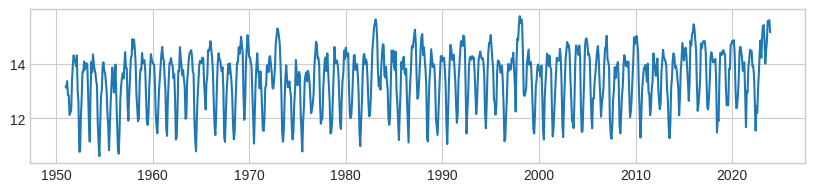

In [262]:
fig, axs = plt.subplots(len(target_columns), 1, figsize=(10, 2 * len(target_columns)), squeeze=False)
for ax, target_column in zip(axs, target_columns):
    ax[0].plot(input_df['date_full'], input_df[target_column])

### Set up zero shot model
The TTM model is hosted on [Hugging Face](https://huggingface.co/ibm-granite/granite-timeseries-ttm-v1), and is retrieved by the wrapper, `TinyTimeMixerForPrediction`. We have one input channel in this example.

In [263]:
# Instantiate the model.
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm-granite/granite-timeseries-ttm-r2",  # Name of the model on Hugging Face
    num_input_channels=len(target_columns),  # tsp.num_input_channels
)

### Create a forecasting pipeline

Set up the forecasting pipeline with the model, setting `frequency` given our knowledge of the sample frequency. In this example we set `explode_forecasts` to `False`, which keeps each sequence of predictions in a list within the dataframe cells. We then make a forecast on the dataset.

In [264]:
# Create a pipeline.
device = "cuda" if torch.cuda.is_available() else "cpu"

pipeline = TimeSeriesForecastingPipeline(
    zeroshot_model,
    timestamp_column=timestamp_column,
    id_columns=[],
    target_columns=target_columns,
    explode_forecasts=False,
    freq="MS",
    device=device,  # Specify your local GPU or CPU.
)

# Make a forecast on the target column given the input data.
zeroshot_forecast = pipeline(input_df)
zeroshot_forecast.tail()

Device set to use cpu


,date_full,tmp_Region6_prediction,tmp_Region6
360,2023-08-01,"[14.486001014709473, 14.71219253540039, 14.968...","[15.560704231262207, 15.520768165588379, 15.59..."
361,2023-09-01,"[15.091449737548828, 15.09327507019043, 15.049...","[15.520768165588379, 15.593423843383789, 15.14..."
362,2023-10-01,"[15.259716033935547, 15.057693481445312, 14.84...","[15.593423843383789, 15.14713191986084, nan, n..."
363,2023-11-01,"[15.180447578430176, 14.873639106750488, 14.65...","[15.14713191986084, nan, nan, nan, nan, nan, n..."
364,2023-12-01,"[14.943117141723633, 14.666633605957031, 14.48...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


### Plot predictions along with the historical data.

The predicted series picks up where the historical data ends, and we can see that it predicts a continuation of the cyclical pattern and an upward trend.

/usr/local/lib/python3.12/dist-packages/tsfm_public/toolkit/time_series_preprocessor.py:1064: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return pd.date_range(


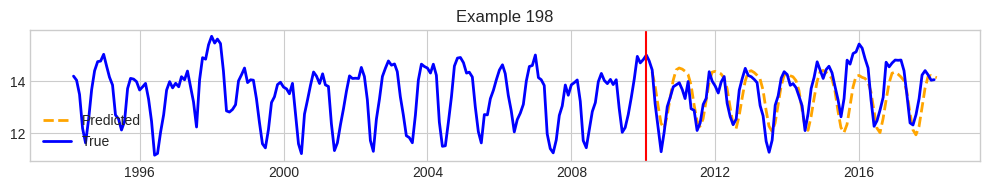

In [265]:
# Plot the historical data and predicted series.
plot_predictions(
    input_df=input_df,
    predictions_df=zeroshot_forecast,
    freq="M",
    timestamp_column=timestamp_column,
    channel=target_column,
    #indices=[-1],
    num_plots=1
)